# 7. An introduction to RLHF

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (04/02/2025)

**Requirements:**
- Python 3 (tested on v3.13.1)
- Matplotlib (tested on v3.10.0)
- Numpy (tested on v2.2.1)
- Torch (tested on v2.7.0+cu124)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Seeding for reproducibility
torch.manual_seed(37)
np.random.seed(21)

### Defining an environment

Let us imagine that we are building a chatbot that needs to respond to user queries intelligently. However, instead of training it on massive datasets, we decided to simulate an environment where the chatbot learns by trial and error—just like an agent in a reinforcement learning game.

Think of this as a chat simulation where a user greets the chatbot first before asking a question. Let us also imagine that an embedding model (not provided here) has transformed the query of the user, transforming raw text into a query embedding vector. The chatbot then perceives the question as an embedding, which is a vector representation of the query. The chatbot then has four possible responses to choose from to greet the user.

- "Hello, how can I help you?" (Score: 10)
- "What do you need?" (Score: 5)
- "Please clarify your question." (Score: 2)
- "Hello lovely." (Score: 1)

Each response has a predefined feedback score, representing how good the answer is. The higher the score, the better the response. Let us pretend that this score is given by a user, after this user has been prompted to evaluate the quality of the chatbot answer, using a satisfaction score between 0 and 10.

This environment allows an AI agent to practice choosing responses, receiving feedback from humans in the form of a score, and learning from its mistakes. Over time, the chatbot could use reinforcement learning techniques (like deep Q-learning) to improve its ability to pick the best response based on the query embeddings.

In short, this is a mini training ground for a chatbot, where it can learn to engage with users based on predefined responses and feedback.

In [3]:
# Simulate environment with query embeddings and predefined responses
class SimpleEnvWithFixedResponses:
    def __init__(self, embedding_dim):
        self.embedding_dim = embedding_dim
        # Predefined responses and their feedback scores
        self.responses = {"Hello, how can I help you?": 10,
                          "What do you need?": 5,
                          "Please clarify your question.": 2,
                          "Hello lovely.": 1}
        # Response options
        self.response_list = list(self.responses.keys())
        # Corresponding feedback scores
        self.feedback_scores = list(self.responses.values())

    def get_query_embedding(self):
        # Simulate a random query embedding vector
        return torch.randn(self.embedding_dim)

    def simulate_human_feedback(self, action):
        # Return the feedback score for the chosen response
        return self.feedback_scores[action]

### Defining our model for deciding on answers to use in response to user queries

Now that we have our chat environment, where the chatbot receives query embeddings and chooses from four possible responses, the next step is to give it a way to make decisions based on the input. This is where the PolicyNetwork comes in, and it is a simple neural network that acts as the chatbot’s decision-making engine.
- The chatbot first receives a query embedding, a vector of size embedding_dim. This vector carries the essence of the user’s question, but on its own, it doesn’t tell us which response is the best.
- The network has two fully connected layer. The first layer maps the input embedding to 64 hidden neurons and applies ReLU activation to introduce non-linearity. The second layer outputs a vector with 4 values (one for each possible response).
- The final layer applies a Softmax activation function, transforming the outputs into a probability distribution for each of the four possible answers.

In [4]:
# Policy network to map query embeddings to response probabilities
class PolicyNetwork(nn.Module):
    def __init__(self, embedding_dim, num_responses):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(nn.Linear(embedding_dim, 64),
                                nn.ReLU(),
                                nn.Linear(64, num_responses),
                                nn.Softmax(dim = -1))

    def forward(self, query_embedding):
        return self.fc(query_embedding)

### Defining our agent

Now that our chatbot has a policy network to decide on responses, it needs a way to improve itself over time. Here, we will use an agent, similar to what we have done in Notebook 6, and use REINFORCE. The RlhfAgent (Reinforcement Learning with Human Feedback Agent) takes the chatbot’s decisions, evaluates how good they were using the preset rewards (who we pretend were given by humans in real time), and updates the policy network accordingly.

It does this by computing probability ratios (how much the new policy deviates from the old one), applying a clipping mechanism to prevent overly drastic updates, and optimizing a loss function that balances exploration and exploitation. 

In [5]:
# REINFORCE agent
class RlhfAgent:
    def __init__(self, policy_net, lr = 1e-3):
        self.policy_net = policy_net
        self.optimizer = optim.Adam(policy_net.parameters(), lr = lr)

    def update_policy(self, query_embeddings, actions, rewards):
        """
        Simple REINFORCE update.
        """
        rewards = torch.tensor(rewards, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        query_embeddings = torch.stack(query_embeddings)
    
        # Get action probabilities and compute log-probs
        action_probs = self.policy_net(query_embeddings)
        dist = torch.distributions.Categorical(probs=action_probs)
        log_probs = dist.log_prob(actions)
    
        # Estimate advantages (just normalized rewards for now)
        advantages = rewards - rewards.mean()
    
        # Policy loss: negative log-prob times advantage
        loss = -(log_probs * advantages).mean()
    
        # Update
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### Training our agent

With everything set up (the chat environment, the policy network, and the REINFORCE update mechanism), we can now train our chatbot using Reinforcement Learning with Human Feedback (RLHF).

The train_rlhf_with_fixed_responses() function below uses 500 training epochs, where the chatbot repeatedly receives query embeddings, selects responses based on its policy, and gets human-like feedback. Each action probability is stored to compare past and new policies. Every 10 interactions, the REINFORCE algorithm (as seen in class) updates the chatbot decision-making model, refining how it maps queries to responses. Over time, the chatbot improves its response selection, maximizing the average reward.

In [6]:
# Training RLHF with query embeddings and fixed responses
def train_rlhf_with_fixed_responses():
    # Dimensionality of query embeddings
    embedding_dim = 8
    # Number of possible responses
    num_responses = 4
    env = SimpleEnvWithFixedResponses(embedding_dim)
    policy_net = PolicyNetwork(embedding_dim, num_responses)
    agent = RlhfAgent(policy_net)
    # Preparing training parameters
    num_epochs = 500
    rewards_over_time = []

    # Training loop
    for epoch in range(num_epochs):
        query_embeddings, actions, rewards = [], [], []
        # Generate training data for one epoch
        for _ in range(10):
            # Simulate 10 queries interactions per epoch
            query_embedding = env.get_query_embedding()
            probs = policy_net(query_embedding)
            action = torch.multinomial(probs, num_samples = 1).item()
            feedback = env.simulate_human_feedback(action)
            query_embeddings.append(query_embedding)
            actions.append(action)
            rewards.append(feedback)
        # Update the policy using REINFORCE formula
        agent.update_policy(query_embeddings, actions, rewards)
        # Record average reward
        avg_reward = np.mean(rewards)
        rewards_over_time.append(avg_reward)
        print(f"Epoch {epoch + 1}/{num_epochs}: Avg Reward = {avg_reward:.2f}")
    return rewards_over_time

### Running the training loop

The training loop below shows the 500 iterations of training and the evolution of the average reward that the agent is getting over each iteration. As can be seen, the rewards are increasing and eventually plateauing in the value 10, indicating that the chatbot has learnt to recognize that answer #1 ("Hello, how can I help you?") is the best way to greet the user, out of the four possible answers.

In [7]:
# Run the training
rewards_over_time = train_rlhf_with_fixed_responses()

Epoch 1/500: Avg Reward = 4.20
Epoch 2/500: Avg Reward = 5.40
Epoch 3/500: Avg Reward = 5.90
Epoch 4/500: Avg Reward = 4.30
Epoch 5/500: Avg Reward = 5.70
Epoch 6/500: Avg Reward = 4.70
Epoch 7/500: Avg Reward = 5.10
Epoch 8/500: Avg Reward = 5.80
Epoch 9/500: Avg Reward = 4.90
Epoch 10/500: Avg Reward = 3.20
Epoch 11/500: Avg Reward = 5.10
Epoch 12/500: Avg Reward = 4.60
Epoch 13/500: Avg Reward = 5.00
Epoch 14/500: Avg Reward = 5.10
Epoch 15/500: Avg Reward = 5.20
Epoch 16/500: Avg Reward = 6.90
Epoch 17/500: Avg Reward = 3.10
Epoch 18/500: Avg Reward = 5.90
Epoch 19/500: Avg Reward = 4.20
Epoch 20/500: Avg Reward = 5.30
Epoch 21/500: Avg Reward = 6.40
Epoch 22/500: Avg Reward = 3.90
Epoch 23/500: Avg Reward = 7.60
Epoch 24/500: Avg Reward = 6.60
Epoch 25/500: Avg Reward = 4.50
Epoch 26/500: Avg Reward = 4.90
Epoch 27/500: Avg Reward = 7.20
Epoch 28/500: Avg Reward = 6.30
Epoch 29/500: Avg Reward = 5.80
Epoch 30/500: Avg Reward = 4.40
Epoch 31/500: Avg Reward = 4.70
Epoch 32/500: Avg

### Display training curves

Finally, we provide a helper function to show the training curves of our RLHF agent.

In [26]:
def display_training_curves(rewards_over_time):
    # After training, plot windowed averaged rewards over time
    r = [float(i) for i in rewards_over_time]
    r2 = [sum(r[i//10:i//10+10])/10 for i in range(0, 4800, 10)]
    plt.plot(r2)
    plt.xlabel("Epoch")
    plt.ylabel("Average Reward")
    plt.title("Reward Evolution During Training")
    plt.show()

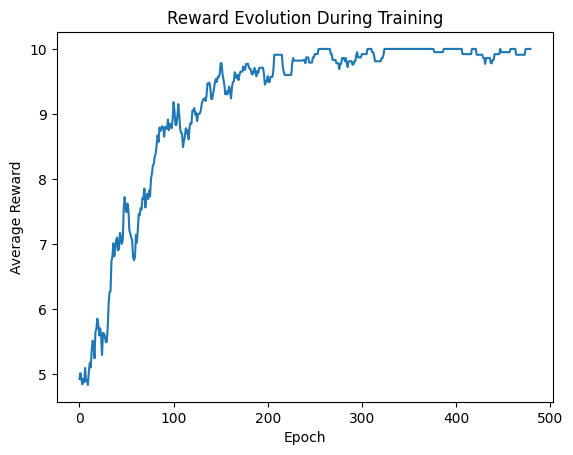

In [27]:
display_training_curves(rewards_over_time)

### What is next?

In practice, we could improve our chatbot.
- We could adjust the answer of the chatbot to the embedding representing the user query.
- We could have the chatbot come up with an answer using an NLP generative model instead of using a dictionary of preset answers.
- We could adjust the human feedback mechanism, by using something simpler (thumbs up/thumbs down) or by ranking different answers.

These are, however, far more sophisticated and out of the scope of this notebook.